In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib ipympl

In [2]:
import matplotlib

font = {'size'   : 24}

matplotlib.rc('font', **font)

In [3]:
matplotlib.rcParams['savefig.pad_inches'] = 0

In [4]:
import scipy.integrate as si
import scipy.signal as ss
import quantities as pq
import neo


#patch quantities with the SI unit Siemens if it does not exist
for symbol, prefix, definition, u_symbol in zip(
    ['siemens', 'S', 'mS', 'uS', 'nS', 'pS'],
    ['', '', 'milli', 'micro', 'nano', 'pico'],
    [pq.A/pq.V, pq.A/pq.V, 'S', 'mS', 'uS', 'nS'],
    [None, None, None, None, u'µS', None]):
    if type(definition) is str:
        definition = lastdefinition / 1000
    if not hasattr(pq, symbol):
        setattr(pq, symbol, pq.UnitQuantity(
            prefix + 'siemens',
            definition,
            symbol=symbol,
            u_symbol=u_symbol))
    lastdefinition = definition


class CSD(object):
    '''Base iCSD class'''
    def __init__(self, lfp, f_type='gaussian', f_order=(3, 1)):
        '''Initialize parent class iCSD
        Parameters
        ----------
        lfp : np.ndarray * quantity.Quantity
            LFP signal of shape (# channels, # time steps)
        f_type : str
            type of spatial filter, must be a scipy.signal filter design method
        f_order : list
            settings for spatial filter, arg passed to  filter design function
        '''
        self.name = 'CSD estimate parent class'
        self.lfp = lfp
        self.f_matrix = np.eye(lfp.shape[0]) * pq.m**3 / pq.S
        self.f_type = f_type
        self.f_order = f_order


    def get_csd(self, ):
        '''
        Perform the CSD estimate from the LFP and forward matrix F, i.e as
        CSD=F**-1*LFP
        Arguments
        ---------
        Returns
        -------
        csd : np.ndarray * quantity.Quantity
            Array with the csd estimate
        '''
        csd = np.linalg.solve(self.f_matrix, self.lfp)

        return csd * (self.f_matrix.units**-1*self.lfp.units).simplified


    def filter_csd(self, csd, filterfunction='convolve'):
        '''
        Spatial filtering of the CSD estimate, using an N-point filter
        Arguments
        ---------
        csd : np.ndarrray * quantity.Quantity
            Array with the csd estimate
        filterfunction : str
            'filtfilt' or 'convolve'. Apply spatial filter using
            scipy.signal.filtfilt or scipy.signal.convolve.
        '''
        if self.f_type == 'gaussian':
            try:
                assert(len(self.f_order) == 2)
            except AssertionError as ae:
                raise ae('filter order f_order must be a tuple of length 2')
        else:
            try:
                assert(self.f_order > 0 and isinstance(self.f_order, int))
            except AssertionError as ae:
                raise ae('Filter order must be int > 0!')
        try:
            assert(filterfunction in ['filtfilt', 'convolve'])
        except AssertionError as ae:
            raise ae("{} not equal to 'filtfilt' or 'convolve'".format(filterfunction))

        if self.f_type == 'boxcar':
            num = ss.boxcar(self.f_order)
            denom = np.array([num.sum()])
        elif self.f_type == 'hamming':
            num = ss.hamming(self.f_order)
            denom = np.array([num.sum()])
        elif self.f_type == 'triangular':
            num = ss.triang(self.f_order)
            denom = np.array([num.sum()])
        elif self.f_type == 'gaussian':
            num = ss.gaussian(self.f_order[0], self.f_order[1])
            denom = np.array([num.sum()])
        elif self.f_type == 'identity':
            num = np.array([1.])
            denom = np.array([1.])
        else:
            print('%s Wrong filter type!' % self.f_type)
            raise

        num_string = '[ '
        for i in num:
            num_string = num_string + '%.3f ' % i
        num_string = num_string + ']'
        denom_string = '[ '
        for i in denom:
            denom_string = denom_string + '%.3f ' % i
        denom_string = denom_string + ']'

        print(('discrete filter coefficients: \nb = {}, \na = {}'.format(num_string, denom_string)))

        if filterfunction == 'filtfilt':
            return ss.filtfilt(num, denom, csd, axis=0) * csd.units
        elif filterfunction == 'convolve':
            csdf = csd / csd.units
            for i in range(csdf.shape[1]):
                csdf[:, i] = ss.convolve(csdf[:, i], num/denom.sum(), 'same')
            return csdf * csd.units


class StandardCSD(CSD):
    '''
    Standard CSD method with and without Vaknin electrodes
    '''

    def __init__(self, lfp,
                 coord_electrode=np.linspace(0, 1400E-6, 15)*pq.m,
                 sigma=0.3*pq.S/pq.m, vaknin_el=True, f_type='gaussian',
                 f_order=(3, 1)):
        '''
        Initialize standard CSD method class with and without Vaknin electrodes.
        Parameters
        ----------
        lfp : np.ndarray * quantity.Quantity
            LFP signal of shape (# channels, # time steps) in units of V
        coord_electrode : np.ndarray * quantity.Quantity
            depth of evenly spaced electrode contact points of shape
            (# contacts, ) in units of m, must be monotonously increasing
        sigma : float * quantity.Quantity
            conductivity of tissue in units of S/m or 1/(ohm*m)
        vaknin_el : bool
            flag for using method of Vaknin to endpoint electrodes
        f_type : str
            type of spatial filter, must be a scipy.signal filter design method
        f_order : list
            settings for spatial filter, arg passed to  filter design function
        '''
        CSD.__init__(self, lfp, f_type, f_order)

        self.name = 'Standard CSD method'
        self.coord_electrode = coord_electrode
        self.sigma = sigma
        self.vaknin_el = vaknin_el

        try:
            assert(np.all(np.diff(np.diff(coord_electrode)))==0)
        except AssertionError as ae:
            print('coord_electrode not monotonously varying')
            raise ae

        if vaknin_el:
            #extend array of lfps by duplicating potential at endpoint contacts
            if lfp.ndim == 1:
                self.lfp = np.empty((lfp.shape[0]+2, )) * lfp.units
            else:
                self.lfp = np.empty((lfp.shape[0]+2, lfp.shape[1])) * lfp.units
            self.lfp[0, ] = lfp[0, ]
            self.lfp[1:-1, ] = lfp
            self.lfp[-1, ] = lfp[-1, ]
        else:
            self.lfp = lfp

        self.f_inv_matrix = self.get_f_inv_matrix()


    def get_f_inv_matrix(self):
        '''Calculate the inverse F-matrix for the standard CSD method'''
        h_val = abs(np.diff(self.coord_electrode)[0])

        f_inv = -np.eye(self.lfp.shape[0])

        #Inner matrix elements  is just the discrete laplacian coefficients
        for j in range(1, f_inv.shape[0]-1):
            f_inv[j, j-1:j+2] = np.array([1., -2., 1.])

        return f_inv * -self.sigma / h_val


    def get_csd(self):
        '''
        Perform the iCSD calculation, i.e: iCSD=F_inv*LFP
        Returns
        -------
        csd : np.ndarray * quantity.Quantity
            Array with the csd estimate
        '''
        csd = np.dot(self.f_inv_matrix, self.lfp)[1:-1, ]
        # `np.dot()` does not return correct units, so the units of `csd` must
        # be assigned manually
        csd_units = (self.f_inv_matrix.units * self.lfp.units).simplified
        csd = csd.magnitude * csd_units

        return csd


class DeltaiCSD(CSD):
    '''
    delta-iCSD method
    '''
    def __init__(self, lfp,
                 coord_electrode=np.linspace(0, 1400E-6, 15)*pq.m,
                 diam=500E-6*pq.m,
                 sigma=0.3*pq.S/pq.m,
                 sigma_top=0.3*pq.S/pq.m,
                 f_type='gaussian', f_order=(3, 1)):
        '''
        Initialize the delta-iCSD method class object
        Parameters
        ----------
        lfp : np.ndarray * quantity.Quantity
            LFP signal of shape (# channels, # time steps) in units of V
        coord_electrode : np.ndarray * quantity.Quantity
            depth of evenly spaced electrode contact points of shape
            (# contacts, ) in units of m
        diam : float * quantity.Quantity
            diamater of the assumed circular planar current sources centered
            at each contact
        sigma : float * quantity.Quantity
            conductivity of tissue in units of S/m or 1/(ohm*m)
        sigma_top : float * quantity.Quantity
            conductivity on top of tissue in units of S/m or 1/(ohm*m)
        f_type : str
            type of spatial filter, must be a scipy.signal filter design method
        f_order : list
            settings for spatial filter, arg passed to  filter design function
        '''
        CSD.__init__(self, lfp)

        try:
            assert(diam.units == coord_electrode.units)
        except AssertionError as ae:
            print('units of coord_electrode ({}) and diam ({}) differ'.format(coord_electrode.units,
                                                                                  diam.units))
            raise ae

        try:
            assert(np.all(np.diff(coord_electrode) > 0))
        except AssertionError as ae:
            print('values of coord_electrode not continously increasing')
            raise ae

        try:
            assert(diam.size == 1 or diam.size == coord_electrode.size)
            if diam.size == coord_electrode.size:
                assert(np.all(diam > 0*diam.units))
            else:
                assert(diam > 0*diam.units)
        except AssertionError as ae:
            print('diam must be positive scalar or of same shape as coord_electrode')
            raise ae
        if diam.size == 1:
            diam = np.ones(coord_electrode.size)*diam

        self.name = 'delta-iCSD method'
        self.coord_electrode = coord_electrode
        self.diam = diam
        self.sigma = sigma
        self.sigma_top = sigma_top
        self.f_type = f_type
        self.f_order = f_order

        #initialize F- and iCSD-matrices
        self.f_matrix = np.empty((self.coord_electrode.size,
                                  self.coord_electrode.size))

        self.f_matrix = self.get_f_matrix()


    def get_f_matrix(self):
        '''Calculate the F-matrix'''
        f_matrix = np.empty((self.coord_electrode.size,
                             self.coord_electrode.size))*self.coord_electrode.units
        for j in range(self.coord_electrode.size):
            for i in range(self.coord_electrode.size):
                f_matrix[j, i] = ((np.sqrt((self.coord_electrode[j] -
                                            self.coord_electrode[i])**2 +
                    (self.diam[j] / 2)**2) - abs(self.coord_electrode[j] -
                                              self.coord_electrode[i])) +
                    (self.sigma - self.sigma_top) / (self.sigma +
                                                     self.sigma_top) *
                    (np.sqrt((self.coord_electrode[j] +
                              self.coord_electrode[i])**2 + (self.diam[j] / 2)**2)-
                    abs(self.coord_electrode[j] + self.coord_electrode[i])))

        f_matrix /= (2 * self.sigma)
        return f_matrix


class StepiCSD(CSD):
    '''step-iCSD method'''
    def __init__(self, lfp,
                 coord_electrode=np.linspace(0, 1400E-6, 15)*pq.m,
                 diam=500E-6*pq.m,
                 h = np.ones(15)*100E-6*pq.m,
                 sigma=0.3*pq.S/pq.m, sigma_top=0.3*pq.S/pq.m,
                 tol=1E-6,
                 f_type='gaussian', f_order=(3, 1)):
        '''
        Initializing step-iCSD method class object
        Parameters
        ----------
        lfp : np.ndarray * quantity.Quantity
            LFP signal of shape (# channels, # time steps) in units of V
        coord_electrode : np.ndarray * quantity.Quantity
            depth of evenly spaced electrode contact points of shape
            (# contacts, ) in units of m
        diam : float or np.ndarray * quantity.Quantity
            diameter(s) of the assumed circular planar current sources centered
            at each contact
        h : float or np.ndarray * quantity.Quantity
            assumed thickness of the source cylinders at all or each contact
        sigma : float * quantity.Quantity
            conductivity of tissue in units of S/m or 1/(ohm*m)
        sigma_top : float * quantity.Quantity
            conductivity on top of tissue in units of S/m or 1/(ohm*m)
        tol : float
            tolerance of numerical integration
        f_type : str
            type of spatial filter, must be a scipy.signal filter design method
        f_order : list
            settings for spatial filter, arg passed to  filter design function
        '''
        CSD.__init__(self, lfp, f_type, f_order)

        try:
            assert(diam.units == coord_electrode.units)
        except AssertionError as ae:
            print('units of coord_electrode ({}) and diam ({}) differ'.format(coord_electrode.units,
                                                                                  diam.units))
            raise ae
        try:
            assert(np.all(np.diff(coord_electrode) > 0))
        except AssertionError as ae:
            print('values of coord_electrode not continously increasing')
            raise ae

        try:
            assert(diam.size == 1 or diam.size == coord_electrode.size)
            if diam.size == coord_electrode.size:
                assert(np.all(diam > 0*diam.units))
            else:
                assert(diam > 0*diam.units)
        except AssertionError as ae:
            print('diam must be positive scalar or of same shape as coord_electrode')
            raise ae
        if diam.size == 1:
            diam = np.ones(coord_electrode.size)*diam

        try:
            assert(h.size == 1 or h.size == coord_electrode.size)
            if h.size == coord_electrode.size:
                assert(np.all(h > 0*h.units))
        except AssertionError as ae:
            print('h must be scalar or of same shape as coord_electrode')
            raise ae
        if h.size == 1:
            h = np.ones(coord_electrode.size)*h


        self.name = 'step-iCSD method'
        self.coord_electrode = coord_electrode
        self.diam = diam
        self.h = h
        self.sigma = sigma
        self.sigma_top = sigma_top
        self.tol = tol

        # compute forward-solution matrix
        self.f_matrix = self.get_f_matrix()


    def get_f_matrix(self):
        '''Calculate F-matrix for step iCSD method'''
        el_len = self.coord_electrode.size
        f_matrix = np.zeros((el_len, el_len))
        for j in range(el_len):
            for i in range(el_len):
                lower_int = self.coord_electrode[i] - self.h[j]/2
                if lower_int < 0:
                    lower_int = self.h[j].units
                upper_int = self.coord_electrode[i] + self.h[j] / 2

                #components of f_matrix object
                f_cyl0 = si.quad(self._f_cylinder,
                                 a=lower_int, b=upper_int,
                                 args=(float(self.coord_electrode[j]),
                                       float(self.diam[j]),
                                       float(self.sigma)),
                                 epsabs=self.tol)[0]
                f_cyl1 = si.quad(self._f_cylinder, a=lower_int, b=upper_int,
                                 args=(-float(self.coord_electrode[j]),
                                       float(self.diam[j]), float(self.sigma)),
                                 epsabs=self.tol)[0]

                #method of images coefficient
                mom = (self.sigma-self.sigma_top)/(self.sigma+self.sigma_top)

                f_matrix[j, i] = f_cyl0 + mom*f_cyl1

        #assume si.quad trash the units
        return f_matrix * self.h.units**2 / self.sigma.units


    def _f_cylinder(self, zeta, z_val, diam, sigma):
        '''function used by class method'''
        f_cyl = 1. / (2.*sigma) * \
            (np.sqrt((diam/2)**2 + ((z_val-zeta))**2) - abs(z_val-zeta))
        return f_cyl


class SplineiCSD(CSD):
    '''spline iCSD method'''
    def __init__(self, lfp,
                 coord_electrode=np.linspace(0, 1400E-6, 15)*pq.m,
                 diam=500E-6*pq.m, sigma=0.3*pq.S/pq.m, sigma_top=0.3*pq.S/pq.m,
                 tol=1E-6,
                 f_type='gaussian', f_order=(3, 1), num_steps=200):
        '''
        Initializing spline-iCSD method class object
        Parameters
        ----------
        lfp : np.ndarray * quantity.Quantity
            LFP signal of shape (# channels, # time steps) in units of V
        coord_electrode : np.ndarray * quantity.Quantity
            depth of evenly spaced electrode contact points of shape
            (# contacts, ) in units of m
        diam : float * quantity.Quantity
            diamater of the assumed circular planar current sources centered
            at each contact
        sigma : float * quantity.Quantity
            conductivity of tissue in units of S/m or 1/(ohm*m)
        sigma_top : float * quantity.Quantity
            conductivity on top of tissue in units of S/m or 1/(ohm*m)
        tol : float
            tolerance of numerical integration
        f_type : str
            type of spatial filter, must be a scipy.signal filter design method
        f_order : list
            settings for spatial filter, arg passed to  filter design function
        num_steps : int
            number of data points for the spatially upsampled LFP/CSD data
        '''
        CSD.__init__(self, lfp, f_type, f_order)

        try:
            assert(diam.units == coord_electrode.units)
        except AssertionError as ae:
            print('units of coord_electrode ({}) and diam ({}) differ'.format(coord_electrode.units,
                                                                                  diam.units))
            raise
        try:
            assert(np.all(np.diff(coord_electrode) > 0))
        except AssertionError as ae:
            print('values of coord_electrode not continously increasing')
            raise ae

        try:
            assert(diam.size == 1 or diam.size == coord_electrode.size)
            if diam.size == coord_electrode.size:
                assert(np.all(diam > 0*diam.units))
        except AssertionError as ae:
            print('diam must be scalar or of same shape as coord_electrode')
            raise ae
        if diam.size == 1:
            diam = np.ones(coord_electrode.size)*diam

        self.name = 'spline-iCSD method'
        self.coord_electrode = coord_electrode
        self.diam = diam
        self.sigma = sigma
        self.sigma_top = sigma_top
        self.tol = tol
        self.num_steps = num_steps

        # compute stuff
        self.f_matrix = self.get_f_matrix()


    def get_f_matrix(self):
        '''Calculate the F-matrix for cubic spline iCSD method'''
        el_len = self.coord_electrode.size
        z_js = np.zeros(el_len+1)
        z_js[:-1] = np.array(self.coord_electrode)
        z_js[-1] = z_js[-2] + float(np.diff(self.coord_electrode).mean())

        # Define integration matrixes
        f_mat0 = np.zeros((el_len, el_len+1))
        f_mat1 = np.zeros((el_len, el_len+1))
        f_mat2 = np.zeros((el_len, el_len+1))
        f_mat3 = np.zeros((el_len, el_len+1))

        # Calc. elements
        for j in range(el_len):
            for i in range(el_len):
                f_mat0[j, i] = si.quad(self._f_mat0, a=z_js[i], b=z_js[i+1],
                                       args=(z_js[j+1],
                                             float(self.sigma),
                                             float(self.diam[j])),
                                       epsabs=self.tol)[0]
                f_mat1[j, i] = si.quad(self._f_mat1, a=z_js[i], b=z_js[i+1],
                                       args=(z_js[j+1], z_js[i],
                                             float(self.sigma),
                                             float(self.diam[j])),
                                       epsabs=self.tol)[0]
                f_mat2[j, i] = si.quad(self._f_mat2, a=z_js[i], b=z_js[i+1],
                                       args=(z_js[j+1], z_js[i],
                                             float(self.sigma),
                                             float(self.diam[j])),
                                       epsabs=self.tol)[0]
                f_mat3[j, i] = si.quad(self._f_mat3, a=z_js[i], b=z_js[i+1],
                                       args=(z_js[j+1], z_js[i],
                                             float(self.sigma),
                                             float(self.diam[j])),
                                       epsabs=self.tol)[0]

                # image technique if conductivity not constant:
                if self.sigma != self.sigma_top:
                    f_mat0[j, i] = f_mat0[j, i] + (self.sigma-self.sigma_top) / \
                                                (self.sigma + self.sigma_top) * \
                            si.quad(self._f_mat0, a=z_js[i], b=z_js[i+1], \
                                    args=(-z_js[j+1],
                                          float(self.sigma), float(self.diam[j])), \
                                    epsabs=self.tol)[0]
                    f_mat1[j, i] = f_mat1[j, i] + (self.sigma-self.sigma_top) / \
                        (self.sigma + self.sigma_top) * \
                            si.quad(self.f_mat1, a=z_js[i], b=z_js[i+1], \
                                args=(-z_js[j+1], z_js[i], float(self.sigma),
                                      float(self.diam[j])), epsabs=self.tol)[0]
                    f_mat2[j, i] = f_mat2[j, i] + (self.sigma-self.sigma_top) / \
                        (self.sigma + self.sigma_top) * \
                            si.quad(self._f_mat2, a=z_js[i], b=z_js[i+1], \
                                args=(-z_js[j+1], z_js[i], float(self.sigma),
                                      float(self.diam[j])), epsabs=self.tol)[0]
                    f_mat3[j, i] = f_mat3[j, i] + (self.sigma-self.sigma_top) / \
                        (self.sigma + self.sigma_top) * \
                            si.quad(self._f_mat3, a=z_js[i], b=z_js[i+1], \
                                args=(-z_js[j+1], z_js[i], float(self.sigma),
                                      float(self.diam[j])), epsabs=self.tol)[0]

        e_mat0, e_mat1, e_mat2, e_mat3 = self._calc_e_matrices()

        # Calculate the F-matrix
        f_matrix = np.eye(el_len+2)
        f_matrix[1:-1, :] = np.dot(f_mat0, e_mat0) + \
                            np.dot(f_mat1, e_mat1) + \
                            np.dot(f_mat2, e_mat2) + \
                            np.dot(f_mat3, e_mat3)

        return f_matrix * self.coord_electrode.units**2 / self.sigma.units


    def get_csd(self):
        '''
        Calculate the iCSD using the spline iCSD method
        Returns
        -------
        csd : np.ndarray * quantity.Quantity
            Array with csd estimate
        '''
        e_mat = self._calc_e_matrices()

        el_len = self.coord_electrode.size

        # padding the lfp with zeros on top/bottom
        if self.lfp.ndim == 1:
            cs_lfp = np.r_[[0], np.asarray(self.lfp), [0]].reshape(1, -1).T
            csd = np.zeros(self.num_steps)
        else:
            cs_lfp = np.vstack((np.zeros(self.lfp.shape[1]),
                                np.asarray(self.lfp),
                                np.zeros(self.lfp.shape[1])))
            csd = np.zeros((self.num_steps, self.lfp.shape[1]))
        cs_lfp *= self.lfp.units

        # CSD coefficients
        csd_coeff = np.linalg.solve(self.f_matrix, cs_lfp)

        # The cubic spline polynomial coefficients
        a_mat0 = np.dot(e_mat[0], csd_coeff)
        a_mat1 = np.dot(e_mat[1], csd_coeff)
        a_mat2 = np.dot(e_mat[2], csd_coeff)
        a_mat3 = np.dot(e_mat[3], csd_coeff)

        # Extend electrode coordinates in both end by min contact interdistance
        h = np.diff(self.coord_electrode).min()
        z_js = np.zeros(el_len + 2)
        z_js[0] = self.coord_electrode[0] - h
        z_js[1:-1] = self.coord_electrode
        z_js[-1] = self.coord_electrode[-1] + h

        # create high res spatial grid
        out_zs = np.linspace(z_js[1], z_js[-2], self.num_steps)

        # Calculate iCSD estimate on grid from polynomial coefficients.
        i = 0
        for j in range(self.num_steps):
            if out_zs[j] >= z_js[i+1]:
                i += 1
            csd[j,] = a_mat0[i, :] + a_mat1[i, :] * \
                            (out_zs[j] - z_js[i]) +\
                a_mat2[i, :] * (out_zs[j] - z_js[i])**2 + \
                a_mat3[i, :] * (out_zs[j] - z_js[i])**3

        csd_unit = (self.f_matrix.units**-1 * self.lfp.units).simplified

        return csd * csd_unit


    def _f_mat0(self, zeta, z_val, sigma, diam):
        '''0'th order potential function'''
        return 1./(2.*sigma) * \
            (np.sqrt((diam/2)**2 + ((z_val-zeta))**2) - abs(z_val-zeta))


    def _f_mat1(self, zeta, z_val, zi_val, sigma, diam):
        '''1'th order potential function'''
        return (zeta-zi_val) * self._f_mat0(zeta, z_val, sigma, diam)


    def _f_mat2(self, zeta, z_val, zi_val, sigma, diam):
        '''2'nd order potential function'''
        return (zeta-zi_val)**2 * self._f_mat0(zeta, z_val, sigma, diam)


    def _f_mat3(self, zeta, z_val, zi_val, sigma, diam):
        '''3'rd order potential function'''
        return (zeta-zi_val)**3 * self._f_mat0(zeta, z_val, sigma, diam)


    def _calc_k_matrix(self):
        '''Calculate the K-matrix used by to calculate E-matrices'''
        el_len = self.coord_electrode.size
        h = float(np.diff(self.coord_electrode).min())

        c_jm1 = np.eye(el_len+2, k=0) / h
        c_jm1[0, 0] = 0

        c_j0 = np.eye(el_len+2) / h
        c_j0[-1, -1] = 0

        c_jall = c_j0
        c_jall[0, 0] = 1
        c_jall[-1, -1] = 1

        tjp1 = np.eye(el_len+2, k=1)
        tjm1 = np.eye(el_len+2, k=-1)

        tj0 = np.eye(el_len+2)
        tj0[0, 0] = 0
        tj0[-1, -1] = 0

        # Defining K-matrix used to calculate e_mat1-3
        return np.dot(np.linalg.inv(np.dot(c_jm1, tjm1) +
                                    2*np.dot(c_jm1, tj0) +
                                    2*c_jall +
                                    np.dot(c_j0, tjp1)),
                      3*(np.dot(np.dot(c_jm1, c_jm1), tj0) -
                         np.dot(np.dot(c_jm1, c_jm1), tjm1) +
                         np.dot(np.dot(c_j0, c_j0), tjp1) -
                         np.dot(np.dot(c_j0, c_j0), tj0)))


    def _calc_e_matrices(self):
        '''Calculate the E-matrices used by cubic spline iCSD method'''
        el_len = self.coord_electrode.size
        ## expanding electrode grid
        h = float(np.diff(self.coord_electrode).min())

        ## Define transformation matrices
        c_mat3 = np.eye(el_len+1) / h

        # Get K-matrix
        k_matrix = self._calc_k_matrix()

        # Define matrixes for C to A transformation:
        tja = np.eye(el_len+2)[:-1, ]
        tjp1a = np.eye(el_len+2, k=1)[:-1, ]


        # Define spline coefficients
        e_mat0 = tja
        e_mat1 = np.dot(tja, k_matrix)
        e_mat2 = 3 * np.dot(c_mat3**2, (tjp1a-tja)) - \
                            np.dot(np.dot(c_mat3, (tjp1a + 2 * tja)), k_matrix)
        e_mat3 = 2 * np.dot(c_mat3**3, (tja-tjp1a)) + \
                            np.dot(np.dot(c_mat3**2, (tjp1a + tja)), k_matrix)

        return e_mat0, e_mat1, e_mat2, e_mat3


def estimate_csd(lfp, coord_electrode, sigma, method='standard', diam=None,
                 h=None, sigma_top=None, tol=1E-6, num_steps=200,
                 f_type='identity', f_order=None):
    """
    Estimates current source density (CSD) from local field potential (LFP)
    recordings from multiple depths of the cortex.
    Parameters
    ----------
    lfp : neo.AnalogSignalArray
        LFP signals from which CSD is estimated.
    coord_electrode : Quantity array
        Depth of evenly spaced electrode contact points.
    sigma : Quantity float
        Conductivity of tissue.
    method : string
        CSD estimation method, either of 'standard': the standard
        double-derivative method, 'delta': delta-iCSD method, 'step':
        step-iCSD method, 'spline': spline-iCSD method. Default is 'standard'
    diam : Quantity float
        Diamater of the assumed circular planar current sources centered at
        each contact, required by iCSD methods (= 'delta', 'step',
        'spline'). Default is `None`.
    h : float or np.ndarray * quantity.Quantity
        assumed thickness of the source cylinders at all or each contact
    sigma_top : Quantity float
        Conductivity on top of tissue. When set to `None`, the same value as
        sigma: is used. Default is `None`.
    tol : float
        Tolerance of numerical integration, required by step- and
        spline-iCSD methods. Default is 1E-6.
    num_steps : int
        Number of data points for the spatially upsampled LFP/CSD data,
        required by spline-iCSD method. Default is 200.
    f_type : string
        Type of spatial 
        used for smoothing of the result, either of
        'boxcar' (uses `scipy.signal.baxcar()`), 'hamming' (
        `scipy.signal.hamming()`), 'triangular' (`scipy.signal.tri()`),
        'gaussian' (`scipy.signal.gaussian`), 'identity' (no smoothing is
        applied). Default is 'identity'.
    f_order : float tuple
        Parameters to be passed to the scipy.signal function associated with
        the specified filter type.
    Returns
    -------
    tuple : (csd, csd_filtered)
        csd : neo.AnalogSignalArray
            Estimated CSD
        csd_filtered : neo.AnalogSignalArray
            Estimated CSD, spatially filtered
    Example
    -------
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import io
    import quantities as pq
    import neo
    import icsd
    #loading test data
    test_data = io.loadmat('test_data.mat')
    #prepare lfp data for use, by changing the units to SI and append
    #quantities, along with electrode geometry and conductivities
    lfp_data = test_data['pot1'] * 1E-3 * pq.V        # [mV] -> [V]
    z_data = np.linspace(100E-6, 2300E-6, 23) * pq.m  # [m]
    diam = 500E-6 * pq.m                              # [m]
    sigma = 0.3 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
    sigma_top = 0. * pq.S / pq.m                      # [S/m] or [1/(ohm*m)]
    lfp = neo.AnalogSignalArray(lfp_data.T, sampling_rate=2.0*pq.kHz)
    # Input dictionaries for each method
    params = {}
    params['delta'] = {
        'method': 'delta',
        'lfp' : lfp,
        'coord_electrode' : z_data,
        'diam' : diam,        # source diameter
        'sigma' : sigma,           # extracellular conductivity
        'sigma_top' : sigma,       # conductivity on top of cortex
    }
    params['step'] = {
        'method': 'step',
        'lfp' : lfp,
        'coord_electrode' : z_data,
        'diam' : diam,
        'sigma' : sigma,
        'sigma_top' : sigma,
        'tol' : 1E-12,          # Tolerance in numerical integration
        }
    params['spline'] = {
        'method': 'spline',
        'lfp' : lfp,
        'coord_electrode' : z_data,
        'diam' : diam,
        'sigma' : sigma,
        'sigma_top' : sigma,
        'num_steps' : 201,      # Spatial CSD upsampling to N steps
        'tol' : 1E-12,
        }
    params['standard'] = {
        'method': 'standard',
        'lfp' : lfp,
        'coord_electrode' : z_data,
        'sigma' : sigma,
        }
    #plot LFP signal
    fig, axes = plt.subplots(len(params)+1, 1, figsize=(6, 8))
    ax = axes[0]
    im = ax.imshow(lfp.magnitude.T, origin='upper', vmin=-abs(lfp).max(),
                   vmax=abs(lfp).max(), cmap='jet_r', interpolation='nearest')
    ax.axis(ax.axis('tight'))
    cb = plt.colorbar(im, ax=ax)
    cb.set_label('LFP (%s)' % lfp_data.dimensionality.string)
    ax.set_xticklabels([])
    ax.set_title('LFP')
    ax.set_ylabel('ch #')
    i_ax = 1
    for method, param in params.items():
        ax = axes[i_ax]
        i_ax += 1
        csd = icsd.estimate_csd(**param)
        im = ax.imshow(csd.magnitude.T, origin='upper', vmin=-abs(csd).max(),
                       vmax=abs(csd).max(), cmap='jet_r',
                       interpolation='nearest')
        ax.axis(ax.axis('tight'))
        ax.set_title(method)
        cb = plt.colorbar(im, ax=ax)
        cb.set_label('CSD (%s)' % csd.dimensionality.string)
        ax.set_xticklabels([])
        ax.set_ylabel('ch #')
    plt.show()
    """

    supported_methods = ('standard', 'delta', 'step', 'spline')
    icsd_methods = ('delta', 'step', 'spline')

    if method not in supported_methods:
        print("Pamareter `method` must be either of {}".format(
            ", ".join(supported_methods)))
        raise ValueError
    elif method in icsd_methods and diam is None:
        print("Parameter `diam` must be specified for iCSD methods: {}".format(
              ", ".join(icsd_methods)))
        raise ValueError

    if not isinstance(lfp, neo.AnalogSignalArray):
        print('Parameter `lfp` must be neo.AnalogSignalArray')
        raise TypeError

    if f_type is not 'identity' and f_order is None:
        print("The order of {} filter must be specified".format(f_type))
        raise ValueError

    lfp_pqarr = lfp.magnitude.T * lfp.units
    if sigma_top is None:
        sigma_top = sigma

    arg_dict = {'lfp': lfp_pqarr,
                'coord_electrode': coord_electrode,
                'sigma': sigma,
                'f_type': f_type,
                'f_order': f_order,
                }
    if method == 'standard':
        csd_estimator = StandardCSD(**arg_dict)
    else:
        arg_dict['diam'] = diam
        arg_dict['sigma_top'] = sigma_top
        if method == 'delta':
            csd_estimator = DeltaiCSD(**arg_dict)
        else:
            arg_dict['tol'] = tol
            if method == 'step':
                arg_dict['h'] = h
                csd_estimator = StepiCSD(**arg_dict)
            else:
                arg_dict['num_steps'] = num_steps
                csd_estimator = SplineiCSD(**arg_dict)
    csd_pqarr = csd_estimator.get_csd()
    csd_pqarr_filtered = csd_estimator.filter_csd(csd_pqarr)
    csd = neo.AnalogSignalArray(csd_pqarr.T, t_start=lfp.t_start,
                                         sampling_rate=lfp.sampling_rate)
    csd_filtered = neo.AnalogSignalArray(csd_pqarr_filtered.T, t_start=lfp.t_start,
                                         sampling_rate=lfp.sampling_rate)

    return csd, csd_filtered

<>:852: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:852: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2236181/ipykernel_157825/198015022.py:852: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if f_type is not 'identity' and f_order is None:


In [5]:
typesL = np.load('EEGs.npy',allow_pickle=True).item()
totalL = np.load('total.npy')[:,:52]

In [6]:
totalL.shape

(3000, 52)

In [7]:
import h5py
f = h5py.File('/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/newCoeffs/b3122c45-e2d9-4205-821c-88f28791dc69/0/neuropixels/coeffsneuropixels.h5')


In [8]:
electrodePos = []
for e in np.arange(51):
    electrodePos.append(f['electrodes']['Neuropixels-384_'+str(e)]['location'][:])
    
electrodePos = np.array(electrodePos)

In [9]:
layers = []

for i in range(51):
    
    l = str(f['electrodes']['Neuropixels-384_'+str(i)]['layer'][()])
    
    if l == "b'Outside'":
        
        layers.append('Outside')
        
    else:
    
        l = l.split('L')[-1]

        layers.append(int(l[0]))

In [10]:
f.close()

In [11]:
breaks = np.where(np.diff(layers)!=0)[0]

In [12]:
breaks

array([17, 29, 34, 43, 46])

In [13]:
meanLfp = np.mean(totalL,axis=0)

In [14]:
totalL -= meanLfp

In [15]:
import bluepysnap as bp
s = bp.Simulation('0/simulation_config.json')
types = np.sort(list(s.circuit.nodes.property_values('mtype')))

In [16]:
byLayer = {}

for layer in np.arange(1,7):
    
    
    for i, t in enumerate(types):

        if str(layer) in t:

            try:
                byLayer[layer] += typesL[t][:,:52]-np.mean(typesL[t][:,:52],axis=0)
            except:
                byLayer[layer] = typesL[t][:,:52]-np.mean(typesL[t][:,:52],axis=0)
                

In [17]:
time = np.arange(0,3000,1)

In [18]:
len(time)

3000

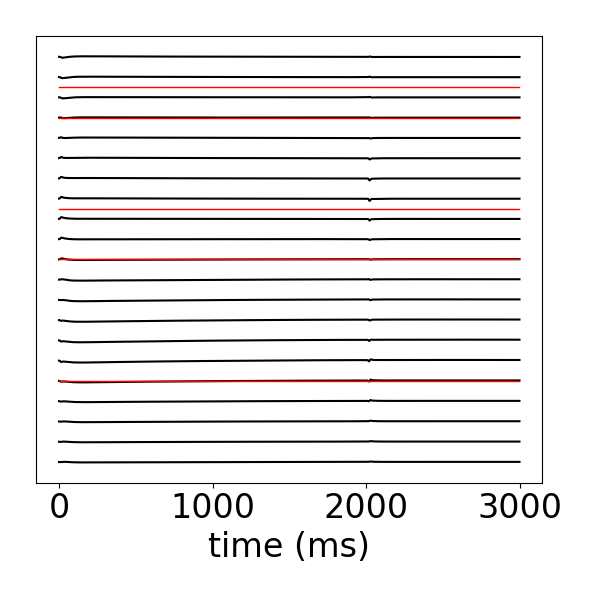

In [19]:
plt.figure(figsize=(6,6))

for i in np.arange(9,51,2):
    plt.plot(time, totalL[:,i]+i*1e-2,c='k')
    
for b in breaks:
    plt.plot([time[0],time[-1]],[b*1e-2,b*1e-2],c='r',linewidth=1)
    
plt.xlabel('time (ms)')
plt.yticks([])

plt.tight_layout()

In [20]:
totalL.shape

(3000, 52)

/gpfs/bbp.cscs.ch/home/tharayil/allen/lib/python3.11/site-packages/quantities/quantity.py:341: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


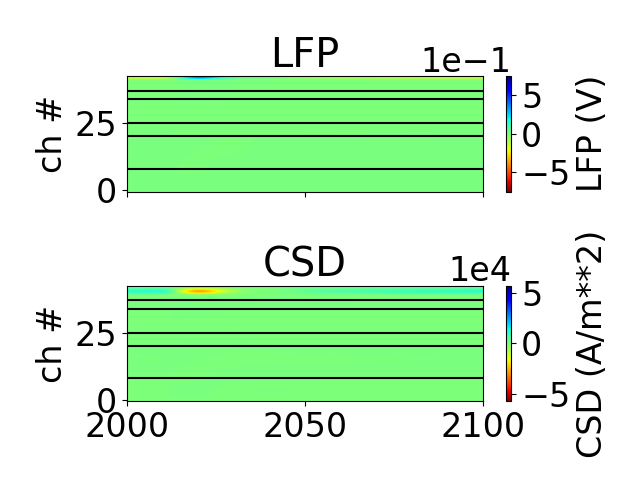

In [21]:
from scipy import io
import quantities as pq
import matplotlib.colors as colors

fig, axes = plt.subplots(2,1)

lfp_data = totalL[:,9:].T * 1E-3 * pq.V        # [mV] -> [V]


z_data = np.arange(51-9) * 1e-6 * pq.m
#z_data = np.linspace(0, 2000E-6, 50) * pq.m  # [m]
diam = 500E-6 * pq.m                              # [m]
h = 1E-6 * pq.m                                 # [m]
sigma = 0.277 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
sigma_top = 0.277 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]

# Input dictionaries for each method

std_input = {
    'lfp' : lfp_data,
    'coord_electrode' : z_data,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}
#Create the different CSD-method class instances. We use the class methods
#get_csd() and filter_csd() below to get the raw and spatially filtered
#versions of the current-source density estimates.
csd_dict = dict(
#     delta_icsd = DeltaiCSD(**delta_input),
#     step_icsd = StepiCSD(**step_input),
#     spline_icsd = SplineiCSD(**spline_input),
    std_csd = StandardCSD(**std_input),
)

for method, csd_obj in csd_dict.items():
    
    
    
    ax = axes[0]
        
    for b in breaks-9:
        ax.plot([0,3000],[b,b],c='k')


    #plot LFP signal
    


    im = ax.imshow(np.array(lfp_data), origin='lower', vmin=-abs(lfp_data).max(), \
          vmax=abs(lfp_data).max(), cmap='jet_r', interpolation='gaussian')
    ax.axis(ax.axis('tight'))
    cb = plt.colorbar(im, ax=ax)
    cb.formatter.set_powerlimits((0, 0))
    cb.set_label('LFP (%s)' % lfp_data.dimensionality.string)
    ax.set_xticklabels([])
#     ax.set_yticklabels([])
    ax.set_title('LFP')
    ax.set_ylabel('ch #')
    
    ax.set_xlim([2000,2100])


    #plot raw csd estimate
    csd = csd_obj.get_csd()


    ax = axes[1]
    
    for b in breaks-9:
        ax.plot([0,3000],[b,b],c='k')


    csd = csd_obj.filter_csd(csd)
    im = ax.imshow(np.array(csd), origin='lower', vmin=-abs(csd).max(), \
          vmax=abs(csd).max(), cmap='jet_r', interpolation='gaussian')
    ax.axis(ax.axis('tight'))
    ax.set_title('CSD')
    cb = plt.colorbar(im, ax=ax)

    cb.set_label('CSD (%s)' % csd.dimensionality.string)
    ax.set_ylabel('ch #')
    
    ax.set_xlim([2000,2100])

#     ax.set_yticklabels([])


    cb.formatter.set_powerlimits((0,0))



plt.tight_layout()
plt.show()




/gpfs/bbp.cscs.ch/home/tharayil/allen/lib/python3.11/site-packages/quantities/quantity.py:341: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


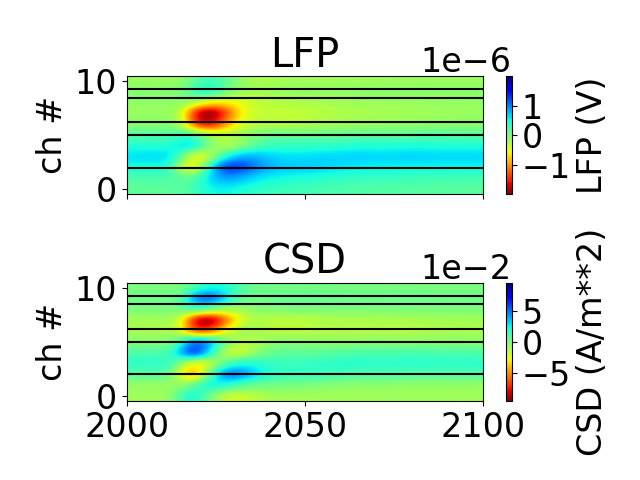

In [18]:
from scipy import io
import quantities as pq
import matplotlib.colors as colors

fig, axes = plt.subplots(2,1)

lfp_data = totalL[:,9:-1:4].T * 1E-3 * pq.V        # [mV] -> [V]


z_data = np.arange(9,51,3) * 1e-6 * pq.m
#z_data = np.linspace(0, 2000E-6, 50) * pq.m  # [m]
diam = 500E-6 * pq.m                              # [m]
h = 1E-6 * pq.m                                 # [m]
sigma = 0.277 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
sigma_top = 0.277 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]

# Input dictionaries for each method

std_input = {
    'lfp' : lfp_data,
    'coord_electrode' : z_data,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}
#Create the different CSD-method class instances. We use the class methods
#get_csd() and filter_csd() below to get the raw and spatially filtered
#versions of the current-source density estimates.
csd_dict = dict(
#     delta_icsd = DeltaiCSD(**delta_input),
#     step_icsd = StepiCSD(**step_input),
#     spline_icsd = SplineiCSD(**spline_input),
    std_csd = StandardCSD(**std_input),
)

for method, csd_obj in csd_dict.items():
    
    
    
    ax = axes[0]
        
    for b in breaks-9:
        ax.plot([0,3000],[b/4,b/4],c='k')

    
    #plot LFP signal
    


    im = ax.imshow(np.array(lfp_data), origin='lower', vmin=-abs(lfp_data).max(), \
          vmax=abs(lfp_data).max(), cmap='jet_r', interpolation='gaussian')
    ax.axis(ax.axis('tight'))
    cb = plt.colorbar(im, ax=ax)
    cb.formatter.set_powerlimits((0, 0))
    cb.set_label('LFP (%s)' % lfp_data.dimensionality.string)
    ax.set_xticklabels([])
#     ax.set_yticklabels([])
    ax.set_title('LFP')
    ax.set_ylabel('ch #')


    #plot raw csd estimate
    csd = csd_obj.get_csd()

    ax.set_xlim([2000,2100])
    ax = axes[1]
    
    for b in breaks-9:
        ax.plot([0,3000],[b/4,b/4],c='k')


    csd = csd_obj.filter_csd(csd)
    im = ax.imshow(np.array(csd), origin='lower', vmin=-abs(csd).max(), \
          vmax=abs(csd).max(), cmap='jet_r', interpolation='gaussian')
    ax.axis(ax.axis('tight'))
    ax.set_title('CSD')
    cb = plt.colorbar(im, ax=ax)

    cb.set_label('CSD (%s)' % csd.dimensionality.string)
    ax.set_ylabel('ch #')

#     ax.set_yticklabels([])
# 
    ax.set_xlim([2000,2100])

    cb.formatter.set_powerlimits((0,0))



plt.tight_layout()
plt.show()




discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


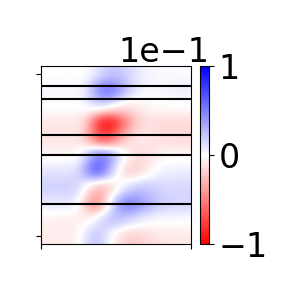

In [26]:
from scipy import io
import quantities as pq
import matplotlib.colors as colors

fig, axes = plt.subplots(1,1,figsize=(3,3))

lfp_data = totalL[:,9:-1:4].T * 1E-3 * pq.V        # [mV] -> [V]


z_data = np.arange(9,51,3) * 1e-6 * pq.m
#z_data = np.linspace(0, 2000E-6, 50) * pq.m  # [m]
diam = 500E-6 * pq.m                              # [m]
h = 1E-6 * pq.m                                 # [m]
sigma = 0.277 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
sigma_top = 0.277 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]

# Input dictionaries for each method

std_input = {
    'lfp' : lfp_data,
    'coord_electrode' : z_data,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}
#Create the different CSD-method class instances. We use the class methods
#get_csd() and filter_csd() below to get the raw and spatially filtered
#versions of the current-source density estimates.
csd_dict = dict(
#     delta_icsd = DeltaiCSD(**delta_input),
#     step_icsd = StepiCSD(**step_input),
#     spline_icsd = SplineiCSD(**spline_input),
    std_csd = StandardCSD(**std_input),
)

for method, csd_obj in csd_dict.items():
    
    
    
    ax = axes
        
#     for b in breaks-9:
#         ax.plot([0,30000],[b/4,b/4],c='k')

    
#     #plot LFP signal
    


#     im = ax.imshow(np.array(lfp_data), origin='lower', vmin=-abs(lfp_data).max(), \
#           vmax=abs(lfp_data).max(), cmap='bwr_r', interpolation='gaussian')
#     ax.axis(ax.axis('tight'))
#     cb = plt.colorbar(im, ax=ax)
#     cb.formatter.set_powerlimits((0, 0))
#     cb.set_label('LFP (%s)' % lfp_data.dimensionality.string)
#     ax.set_xticklabels([])
# #     ax.set_yticklabels([])
#     ax.set_title('LFP')
#     ax.set_ylabel('ch #')


    #plot raw csd estimate
    csd = csd_obj.get_csd()

    ax.set_xlim([20000,20500])
    # ax = axes[1]
    
    for b in breaks-9:
        ax.plot([0,30000],[b/4,b/4],c='k')


    csd = csd_obj.filter_csd(csd)
    im = ax.imshow(np.array(csd), origin='lower', vmin=-.1, \
          vmax=.1, cmap='bwr_r', interpolation='gaussian')
    ax.axis(ax.axis('tight'))
    # ax.set_title('CSD')
    cb = plt.colorbar(im, ax=ax)

    # cb.set_label('CSD (%s)' % csd.dimensionality.string)
#     ax.set_ylabel('ch #')

    ax.set_yticklabels([])
    ax.set_xticklabels([])
# 
    ax.set_xlim([2000,2050])

    cb.formatter.set_powerlimits((0,0))



plt.tight_layout()
plt.show()





array([[-7.88761481e-04, -7.50015520e-04, -5.34276254e-04, ...,
        -8.85350513e-03, -8.86520983e-03, -8.87674067e-03],
       [-6.74228804e-04, -6.40800635e-04, -4.54828052e-04, ...,
        -8.04426460e-03, -8.02165413e-03, -7.99914154e-03],
       [ 8.21983391e-04,  7.54464204e-04,  3.78134815e-04, ...,
         9.37007825e-03,  9.43995605e-03,  9.49871957e-03],
       ...,
       [-1.03265536e-04, -9.05593545e-05, -1.03518475e-05, ...,
        -4.34606357e-04, -4.41600429e-04, -4.39564162e-04],
       [ 8.05353588e-05,  3.01314361e-05, -2.59651241e-04, ...,
         2.95040491e-03,  2.94892171e-03,  2.94618351e-03],
       [-1.70518446e-04, -2.16693648e-04, -4.86461762e-04, ...,
        -5.47818872e-04, -5.51079329e-04, -5.53859460e-04]]) * A/m**2

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


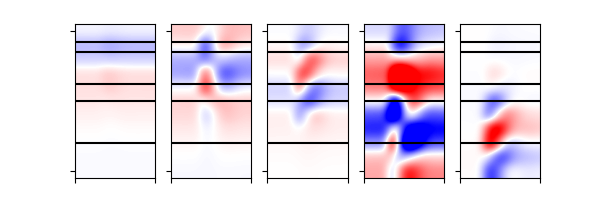

In [30]:
from scipy import io
import quantities as pq
import matplotlib.colors as colors

fig, axes = plt.subplots(1,5,figsize=(6,2))

for i in np.arange(2,7):

    lfp_data = byLayer[i][:,9:-1:4].T * 1E-3 * pq.V        # [mV] -> [V]

    z_data = np.arange(51) * 1e-6 * pq.m
    #z_data = np.linspace(0, 2000E-6, 50) * pq.m  # [m]
    diam = 630E-6 * pq.m                              # [m]
    h = 1E-6 * pq.m                                 # [m]
    sigma = 0.374 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
    sigma_top = 0.374 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]

    # Input dictionaries for each method

    std_input = {
        'lfp' : lfp_data,
        'coord_electrode' : z_data,
        'sigma' : sigma,
        'f_type' : 'gaussian',
        'f_order' : (3, 1),
    }
    #Create the different CSD-method class instances. We use the class methods
    #get_csd() and filter_csd() below to get the raw and spatially filtered
    #versions of the current-source density estimates.
    csd_dict = dict(
        std_csd = StandardCSD(**std_input),
    )

    for method, csd_obj in csd_dict.items():


    #     #plot LFP signal
    #     ax = axes[0][i-2]
        
    #     for b in breaks:
    #         ax.plot([0,30000],[b,b],c='k')


    #     im = ax.imshow(np.array(lfp_data), origin='lower', vmin=-2.5e-5, \
    #               vmax=2.5e-5, cmap='jet_r', interpolation='gaussian')
    #     ax.axis(ax.axis('tight'))
    #     #cb = plt.colorbar(im, ax=ax)
    #     #cb.set_label('LFP (%s)' % lfp_data.dimensionality.string)
    #     ax.set_xticklabels([])
    #     ax.set_yticklabels([])
    #     ax.set_xlim([20000,20500])
    #     #     ax.set_title('LFP')
    # #         ax.set_ylabel('ch #')


        #plot raw csd estimate
        csd = csd_obj.get_csd()


        ax = axes[i-2]
        
        for b in breaks-9:
            ax.plot([0,30000],[b/4,b/4],c='k')


        csd = csd_obj.filter_csd(csd)
        im = ax.imshow(np.array(csd), origin='lower', vmin=-.1, \
              vmax=.1, cmap='bwr_r', interpolation='gaussian')
        ax.axis(ax.axis('tight'))
        
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlim([2000,2050])
        #     ax.set_title('CSD')
       # cb = plt.colorbar(im, ax=ax)

       # cb.set_label('CSD (%s)' % csd.dimensionality.string)
    #         ax.set_ylabel('ch #')


        # cb.formatter.set_powerlimits((0,0))



    # plt.tight_layout()
    # plt.show()





In [34]:
csd

array([[-1.00951433e-04, -9.28098904e-05, -5.26414603e-05, ...,
        -1.73800011e-03, -1.76048841e-03, -1.78535797e-03],
       [-1.89748993e-04, -1.73193453e-04, -8.44384965e-05, ...,
        -3.24354800e-03, -3.22910238e-03, -3.21392606e-03],
       [-5.93106351e-05, -4.77892920e-05,  2.00658615e-05, ...,
        -9.86548863e-04, -9.51449620e-04, -9.16775294e-04],
       ...,
       [-5.15220924e-06, -6.61175280e-06, -1.54458288e-05, ...,
        -5.15563897e-05, -5.29536632e-05, -5.42140454e-05],
       [-3.27793627e-05, -3.22260894e-05, -2.88898060e-05, ...,
        -5.62588181e-04, -5.62937552e-04, -5.63231670e-04],
       [-3.24789943e-05, -3.13768540e-05, -2.46771222e-05, ...,
        -5.72255089e-04, -5.72420564e-04, -5.72480770e-04]]) * A/m**2